In [1]:
from datasets import load_dataset

In [2]:
data = load_dataset('pinecone/image-set', split='train', revision='e7d39fc')
data

Dataset({
    features: ['image_bytes', 'image'],
    num_rows: 21
})

In [3]:
import matplotlib.pyplot as plt

In [4]:
from base64 import b64decode
import cv2
import numpy as np

def process_fn(sample):
    image_bytes = b64decode(sample['image_bytes'])
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    return image

images = [process_fn(img) for img in data]

In [5]:
im = images[0]
im.shape

(1600, 2560, 3)

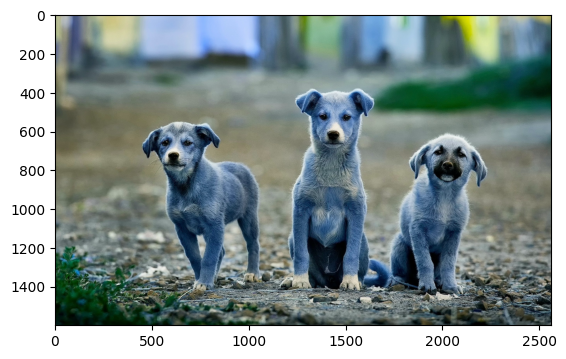

In [6]:
plt.imshow(im);

In [7]:
print(images[0].shape)
rgb_image = np.flip(images[0], 2)
rgb_image.shape

(1600, 2560, 3)


(1600, 2560, 3)

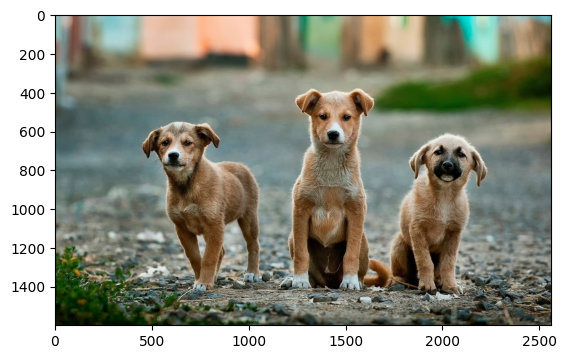

In [8]:
plt.imshow(rgb_image);

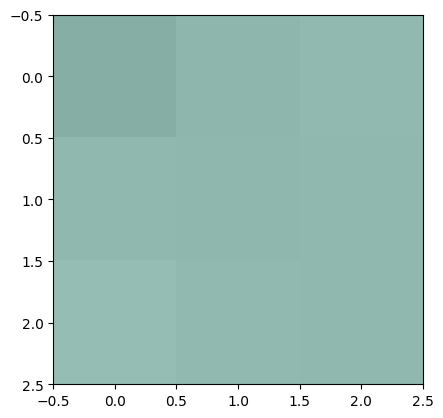

In [9]:
plt.imshow(rgb_image[:3, :3, :]);

In [10]:
img_vec = rgb_image.reshape(1, -1, 3)
img_vec.shape

(1, 4096000, 3)

In [11]:
red = img_vec[0, :, 0]
green = img_vec[0, :, 1]
blue = img_vec[0, :, 2]
red.shape, green.shape, blue.shape

((4096000,), (4096000,), (4096000,))

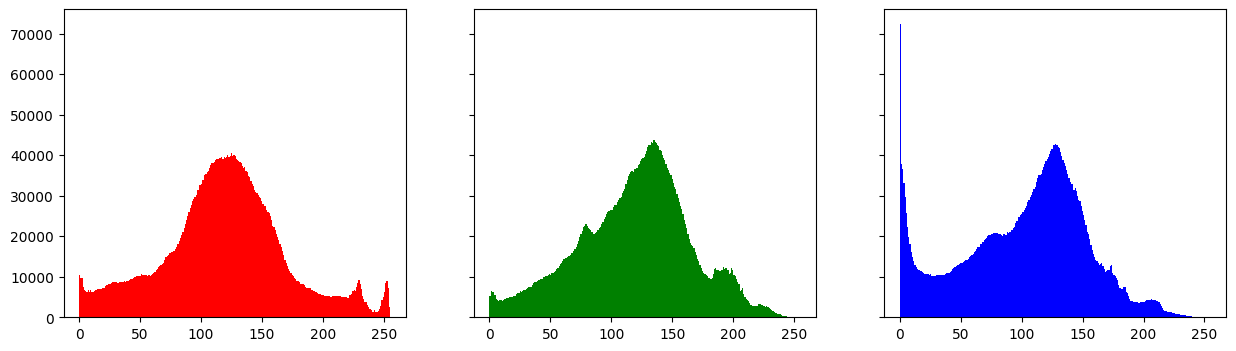

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].hist(red, bins=256, color='r');
axs[1].hist(green, bins=256, color='g');
axs[2].hist(blue, bins=256, color='b');

In [13]:
def build_hist(image, bins=256):
    rgb_image = np.flip(image, 2)
    plt.figure(figsize=(3, 3))
    plt.imshow(rgb_image)
    image_vec = rgb_image.reshape(1, -1, 3)
    div = 256/bins
    bins_vec = (image_vec/div).astype(int)
    red = bins_vec[0, :, 0]
    green = bins_vec[0, :, 1]
    blue = bins_vec[0, :, 2]
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
    axs[0].hist(red, bins=bins, color='r')
    axs[1].hist(green, bins=bins, color='g')
    axs[2].hist(blue, bins=bins, color='b')
    plt.show()

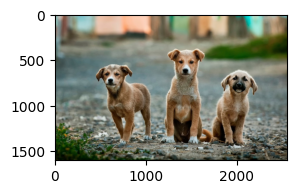

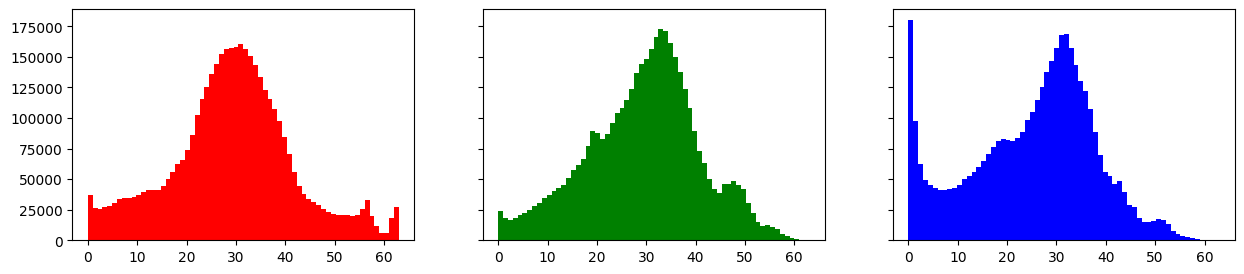

In [14]:
build_hist(images[0], bins=64)

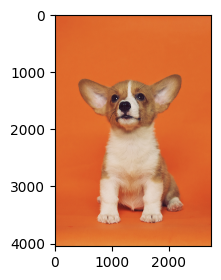

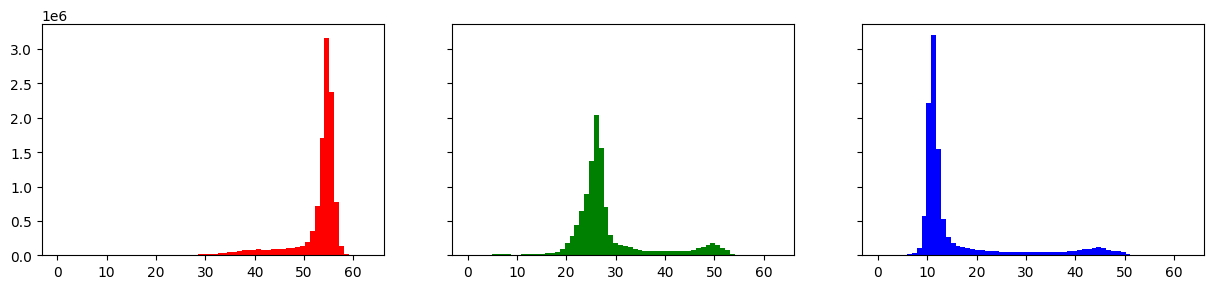

In [15]:
build_hist(images[5], bins=64)

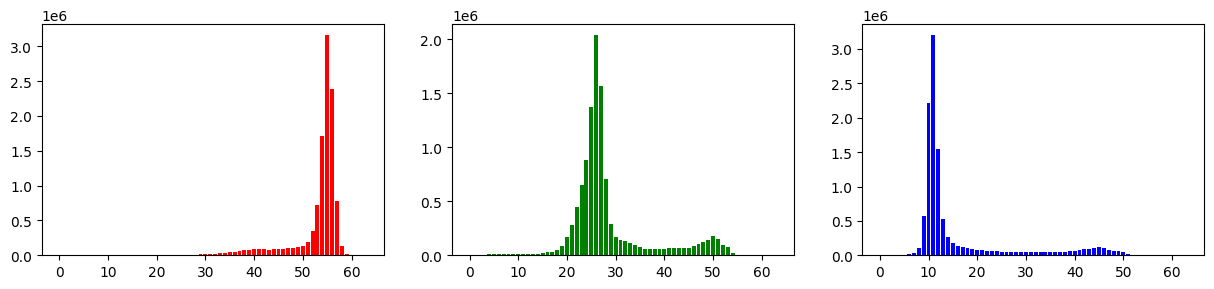

In [16]:
red_hist = cv2.calcHist([images[5]], [2], None, [64], [0, 256]).flatten()
green_hist = cv2.calcHist([images[5]], [1], None, [64], [0, 256]).flatten()
blue_hist = cv2.calcHist([images[5]], [0], None, [64], [0, 256]).flatten()

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].bar(range(len(red_hist)), red_hist, color='r');
axs[1].bar(range(len(green_hist)), green_hist, color='g');
axs[2].bar(range(len(blue_hist)), blue_hist, color='b');

In [17]:
def get_vector(image, bins=32):
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green  = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    vec = np.concatenate([red, green, blue], axis=0)
    return vec.reshape(-1)

In [18]:
vec = get_vector(images[0])
vec.shape

(96,)

In [19]:
def cos_sim(a, b):
    return np.dot(a, b)/ (np.linalg.norm(a) * np.linalg.norm(b))

In [20]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image))
len(image_vectors)

21

In [23]:
rgb_images =[np.flip(image, 2) for image in images]

In [24]:
def search(idx, top_k=5):
    q_vec = image_vectors[idx]
    dist = []
    for _, vec in enumerate(image_vectors):
        dist.append(cos_sim(q_vec, vec))
    top_idx = np.argpartition(dist, -top_k)[-top_k:]
    return top_idx

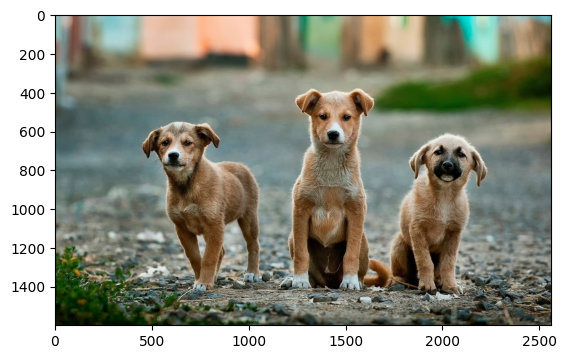

In [25]:
q_img = rgb_images[0]
plt.imshow(q_img);

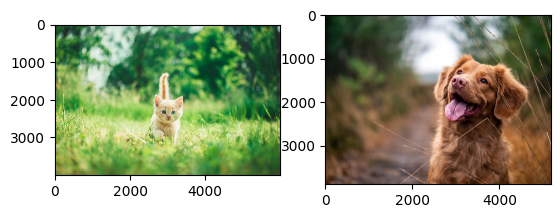

In [31]:
top_match = search(0, 5)
_, axs = plt.subplots(1, 2)
axs[0].imshow(rgb_images[top_match[0]])
axs[1].imshow(rgb_images[top_match[1]]);

In [62]:
import ipywidgets as widgets
from IPython.display import display

# Create a FileUpload widget
uploader = widgets.FileUpload()

# Display the widget
display(uploader)


FileUpload(value=(), description='Upload')

In [46]:
uploader.value

({'name': 'Screenshot.png',
  'type': 'image/png',
  'size': 635485,
  'content': <memory at 0x7f74c3949f00>,
  'last_modified': datetime.datetime(2024, 4, 29, 11, 1, 59, 227000, tzinfo=datetime.timezone.utc)},)

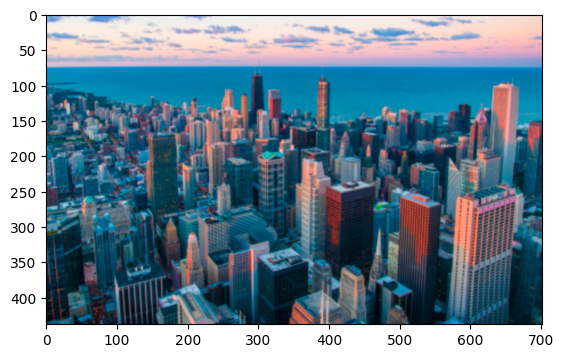

In [56]:
img_array = np.frombuffer(uploader.value[0]['content'], dtype=np.uint8)
img = cv2.imdecode(img_array,  cv2.IMREAD_COLOR)
plt.imshow(np.flip(img, 2));

In [57]:
def search(img, top_k=5):
    q_vec = get_vector(img)
    dist = []
    for _, vec in enumerate(image_vectors):
        dist.append(cos_sim(q_vec, vec))
    top_idx = np.argpartition(dist, -top_k)[-top_k:]
    return top_idx

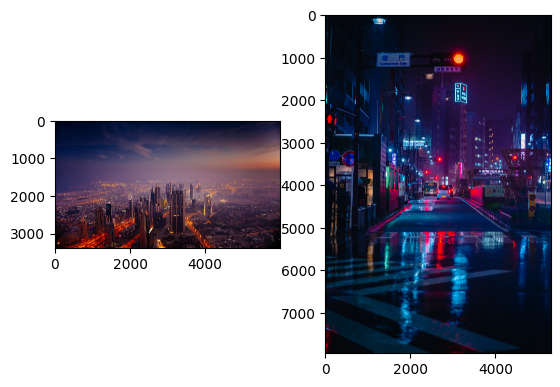

In [58]:
top_match = search(img, 5)
_, axs = plt.subplots(1, 2)
axs[0].imshow(rgb_images[top_match[0]])
axs[1].imshow(rgb_images[top_match[1]]);

In [63]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value=(), description='Upload')

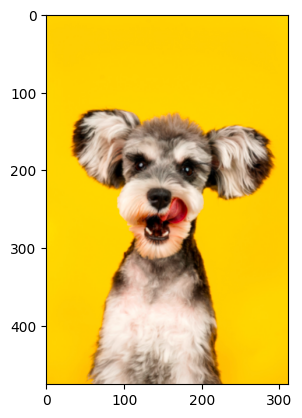

In [64]:
img_array = np.frombuffer(uploader.value[0]['content'], dtype=np.uint8)
img = cv2.imdecode(img_array,  cv2.IMREAD_COLOR)
plt.imshow(np.flip(img, 2));

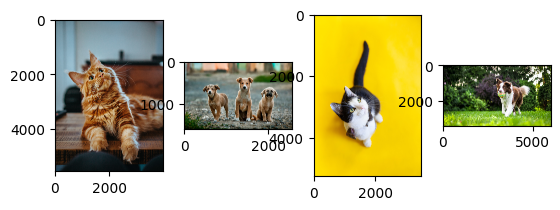

In [68]:
top_match = search(img, 5)
_, axs = plt.subplots(1, 4)
axs[0].imshow(rgb_images[top_match[0]])
axs[1].imshow(rgb_images[top_match[1]]);
axs[2].imshow(rgb_images[top_match[2]]);
axs[3].imshow(rgb_images[top_match[3]]);